<a href="https://colab.research.google.com/github/krumeto/article-vectorisation-eda/blob/main/Article_Vectorisation_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from functools import wraps
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report
from sklearn.linear_model import RidgeClassifier

from sentence_transformers import SentenceTransformer, util
import torch

import gensim
from dotenv import load_dotenv
load_dotenv()

True

# This notebook highlights the ease of use of a scikit-learn type API vs. the native APIs of gensim and other libraries. 

The package used is `articlevectorizer`, but for more mature project, please try `embetter` by Vincent Warmerdam. 
Exploration with the original APIs can be found in the neighbour notebook `Article_Vectorisation_Exploration.ipynb`

In [2]:
from articlevectorizer.vectorize import SentenceTransformerVectorizer, Doc2VecVectorizer

### Helper functions

Intentionally kept in the notebook to allow for easier exploration. 

In [3]:
def log_step(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        tic = dt.datetime.now()
        result = func(*args, **kwargs)
        time_taken = str(dt.datetime.now() - tic)
        print(f"just ran step {func.__name__} shape={result.shape} took {time_taken}s")
        return result
    return wrapper

@log_step
def pull_data():
    return pd.read_csv('medium-articles.zip', usecols = ['title', 'text', 'tags'])

@log_step
def extract_first_tag(dataf):
    return dataf.assign(
        first_tag = lambda d: d['tags'].str.split(",", expand=True)[0].str.replace("[",'', regex=True)
        )
    
@log_step
def keep_topn_first_tags(dataf, n=10):
    top_n_tags = dataf['first_tag'].value_counts().nlargest(n).index.to_list()
    return dataf.loc[lambda d: d['first_tag'].isin(top_n_tags)]

@log_step
def drop_too_long_and_short_articles(dataf, low = 200, high = 2000):
    return (dataf.
            assign(appr_n_words = lambda d: d.text.str.split().str.len()).
            loc[lambda d: (d.appr_n_words > low) & (d.appr_n_words < high)].
            drop('appr_n_words', axis = 1)
          )

## Data Load and Split

You'd need a Kaggle username and key stored in a .env file. The format looks like this:

KAGGLE_USERNAME=yourusername

KAGGLE_KEY=yourkey

In [4]:
! kaggle datasets download -d fabiochiusano/medium-articles

medium-articles.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
data = (pull_data().
        pipe(drop_too_long_and_short_articles).
        pipe(extract_first_tag).
        pipe(keep_topn_first_tags)
        )

just ran step pull_data shape=(192368, 3) took 0:00:19.009390s
just ran step drop_too_long_and_short_articles shape=(151656, 3) took 0:00:25.684527s
just ran step extract_first_tag shape=(151656, 4) took 0:00:05.834175s
just ran step keep_topn_first_tags shape=(11797, 4) took 0:00:00.071051s


In [6]:
train_data, test_data =  train_test_split(data,test_size=0.10, random_state=42, stratify = data.first_tag)
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# The resets help the closest article comparisson below run
train_data = train_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

y_train = train_data.first_tag
y_test = test_data.first_tag

train_data.head()

Train data shape: (10617, 4)
Test data shape: (1180, 4)


,title,text,tags,first_tag
0,"If You Want To Stop Procrastinating, You Need ...",There is this notion in the self-help world th...,"['Self Improvement', 'Motivation', 'Self', 'Pr...",'Self Improvement'
1,Applying Behavioral Science to Machine Learning,Applying Behavioral Science to Machine Learnin...,"['Machine Learning', 'Deep Learning', 'Data Sc...",'Machine Learning'
2,Image clustering using Transfer learning,Clustering is an interesting field of Unsuperv...,"['Machine Learning', 'Cluster', 'Deep Learning...",'Machine Learning'
3,The Unofficial Weekly Stratis Retrospect #60 —...,It’s time for The Unofficial Weekly Stratis Re...,"['Blockchain', 'Bitcoin', 'Stratis', 'Stratisw...",'Blockchain'
4,Readymade Grocery App Version 2.2.0 has Released,We are delighted to announce that we have laun...,"['Startup', 'Grocery Shopping', 'Flutter', 'Da...",'Startup'


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10617 entries, 0 to 10616
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      10617 non-null  object
 1   text       10617 non-null  object
 2   tags       10617 non-null  object
 3   first_tag  10617 non-null  object
dtypes: object(4)
memory usage: 331.9+ KB


<AxesSubplot: title={'center': 'Histogram of approximate number of words per article'}, ylabel='Frequency'>

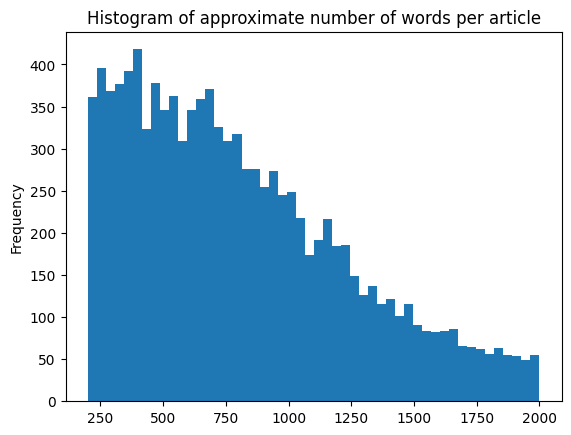

In [8]:
(train_data.
 assign(appr_n_words = lambda d: d.text.str.split().str.len()).
 appr_n_words.
 plot.
 hist(bins = 50, title = 'Histogram of approximate number of words per article')
)

In [9]:
train_data.first_tag.value_counts()

'Machine Learning'    1606
'Blockchain'          1253
'Self Improvement'    1100
'Politics'            1048
'Life Lessons'        1042
'Technology'          1017
'Startup'              948
'Programming'          920
'Health'               855
'Cryptocurrency'       828
Name: first_tag, dtype: int64

## TF-IDF 

In [10]:
corpus = train_data.text

vectorizer = TfidfVectorizer(stop_words = 'english', max_features=40_000)
vectorized_corpus = vectorizer.fit_transform(corpus)

print(vectorized_corpus.shape)
print("Note that the rows are the number of documents, while the columns equal the number of tokens")

(10617, 40000)
Note that the rows are the number of documents, while the columns equal the number of tokens


In [11]:
# Title is Optimizing Kafka for the cloud
new_document = ["""
By Ambud Sharma | Software Engineer, Logging team Takeaways Developing locality aware systems and balancing algorithms can help substantially reduce cost Making Kafka Producer and Consumer rack aware helps efficiently route traffic Data-driven engineering decision making is critical to continuously improve systems One of the fundamental principles when operating in the cloud is to ensure applications safeguard against outages. A common way to achieve this is to spread an application’s deployment across multiple failure domains. In a public cloud environment, Availability Zone (AZ) can serve as a failure domain. We can use multiple AZs to provide fault tolerance for an application. Distributed systems like HDFS are traditionally made rack aware to improve fault tolerance by spreading replicas across multiple racks within a datacenter. However, using AZs as rack information is a common practice when running in cloud environments. This enables spreading data copies across multiple AZs, thereby providing fault tolerance in case one fails. While replicating data across AZs provides fault tolerance, it does come at a premium in form of AZ transfer costs. At Pinterest, we use Kafka extensively as a scalable, fault tolerant distributed message bus to power several key services like user action counting and change data capture (CDC). Since we have Kafka running at a very large scale, we need to be mindful of AZ transfer costs and run as efficiently as possible, and so we focused on reducing the amount of data transferred across AZ. When a Kafka cluster has brokers spread across multiple AZs, it results in three types of cross AZ network traffic: Inter-broker replication traffic Traffic from Producers in different AZs Traffic from Consumers in different AZs Out of the above traffic types we need 1 for fault tolerance. However, 2 and 3 are unwanted side effects that cause additional cost which, in theory, can be eliminated. Design There are two potential ways to solve this problem. Approach 1 We can make our Producers and Consumers write/read data only for partitions whose leaders share the same AZ to make them more cost efficient. Approach 2 Alternatively we could deploy AZ specific Kafka clusters, but in order to achieve this any other real-time consumers would need to make their business logic AZ aware. In the interest of simplicity, we chose to go with Approach 1 since it minimized code and stack changes. Producer / Consumer AZ awareness can be achieved by looking up the rack information for the leader broker of the partition we are trying to read/write to, and change the partitioning logic for producers and assignments for consumer. In Kafka, the broker’s rack information is part of the PartitionInfo metadata object that is shared with Kafka clients (both consumers and producers). Therefore, we deployed rack awareness to our Kafka clusters, where each broker publishes the AZ it’s in as node rack info. We started this initiative with our biggest producer and consumer applications for Kafka, logging agent and S3 transporter. Producer AZ Awareness Our logging agent is responsible for reading data from log files and shipping them to Kafka in microbatches. The agent also lets users configure how logs are partitioned across a topic’s partitions. One key design of our logging agent is the ability to pre-partition the data before calling Kafka’s producer.send(). This allows us to add more advanced routing. To make it AZ aware, we added ability for the logging agent to look up AZ info for the node it’s running on using the EC2 Metadata API. Next, we enhanced our partitioner to leverage rack information in Kafka’s producer metadata to limit writes to only partitions for which leaders are in the same AZ as the logging agent. (This change was only applicable to topics that didn’t use key based partitioning since ordering couldn’t be guaranteed after AZ awareness change, as a partition switches AZ.) Consumer AZ Awareness S3 transporter is responsible for reading logs from Kafka and persisting them to S3 for further processing. We tried something similar to the producer for S3 transporter. Our S3 transporter doesn’t use Kafka consumer assignments. Rather, it uses its own partition assignment system. This allows us to preserve locality in case of node restarts or has temporary network isolation, thus reducing the amount of data that needs to be replayed for a given batch. We make each S3 transporter worker look up and publish its AZ info to Zookeeper, which helps the S3 transporter master assign Kafka partitions to the workers based on their rack (AZ). If we are unable to look up the (rack) AZ information of a partition, we degrade to assignment across all available workers. Results We rolled out AZ aware S3 transporter to production, which resulted in more than 25% savings in AZ transfer cost for Logging. We’re currently in the process of slowly rolling out AZ aware logging agent to further reduce our AZ transfer costs. We’re also working to extend this design to standard Kafka Producers and Consumers to help us extend our savings to other applications as well, which may include KIP-392 once it’s implemented. Acknowledgements: Huge thanks to Eric Lopez, Henry Cai, Heng Zhang, Ping-Min Lin, Vahid Hashemian, Yi Yin, Yinian Qi and Yu Yang who helped with improving Logging at Pinterest. Also, thanks to Kalim Moghul for helping us with this effort.
"""]

new_doc_vector = vectorizer.transform(new_document)

In [12]:
sim = cosine_similarity(X = vectorized_corpus, Y = new_doc_vector)
sim

array([[0.00573183],
       [0.016963  ],
       [0.00968857],
       ...,
       [0.01157422],
       [0.02053723],
       [0.00866598]])

In [13]:
# Extract Index of Maximum valued similar document
argmax = np.argmax(sim)
print(f"Index of maximum valued similar data: {argmax}")
print("Retrieved Document Header:")
print(train_data['title'][argmax])
train_data["text"][argmax][:100]

Index of maximum valued similar data: 9349
Retrieved Document Header:
What is Kafka?


'What is Kafka?\n\nWhat is Kafka?\n\nKafka is a streaming platform that can be used for storing, reading '

In [14]:
# Super expensive
X_tf_idf = vectorized_corpus.todense()

ridge_tf_idf = RidgeClassifier(tol=1e-2, solver="sag")
ridge_tf_idf.fit(X_tf_idf, y_train)

X_test_tf_idf = vectorizer.transform(test_data.text)
pred_tf_idf = ridge_tf_idf.predict(X_test_tf_idf)

print(classification_report(y_test, pred_tf_idf))

/Users/krum.arnaudov/Projects/article-vectorisation-eda/av39/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


                    precision    recall  f1-score   support

      'Blockchain'       0.62      0.76      0.69       139
  'Cryptocurrency'       0.59      0.42      0.49        92
          'Health'       0.77      0.83      0.80        95
    'Life Lessons'       0.44      0.45      0.44       116
'Machine Learning'       0.84      0.92      0.88       179
        'Politics'       0.82      0.86      0.84       117
     'Programming'       0.69      0.75      0.72       102
'Self Improvement'       0.48      0.49      0.49       122
         'Startup'       0.73      0.66      0.69       105
      'Technology'       0.56      0.36      0.44       113

          accuracy                           0.67      1180
         macro avg       0.66      0.65      0.65      1180
      weighted avg       0.66      0.67      0.66      1180



In [15]:
del X_tf_idf

## gensim's doc2vec

In [16]:
doc2vec_model = Doc2VecVectorizer( vector_size=50, min_count=2, epochs=15, dm=1)

gensim_vectors = doc2vec_model.fit_transform(train_data.text)

2022-12-10 16:41:38,536 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d50,n5,w5,mc2,s0.001,t3>', 'datetime': '2022-12-10T16:41:38.536542', 'gensim': '4.2.0', 'python': '3.9.13 (v3.9.13:6de2ca5339, May 17 2022, 11:23:25) \n[Clang 6.0 (clang-600.0.57)]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2022-12-10 16:41:38,537 : INFO : collecting all words and their counts
2022-12-10 16:41:38,537 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2022-12-10 16:41:40,021 : INFO : PROGRESS: at example #10000, processed 7834665 words (5286049 words/s), 94487 word types, 0 tags
2022-12-10 16:41:40,122 : INFO : collected 97388 word types and 10617 unique tags from a corpus of 10617 examples and 8323506 words
2022-12-10 16:41:40,122 : INFO : Creating a fresh vocabulary
2022-12-10 16:41:40,391 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 59869 unique words (61.47% of original 97388, drops 37519)', 'datetime

In [18]:
gensim_vectors.shape

(10617, 50)

In [19]:
new_doc_gensim_vector = doc2vec_model.transform(new_document)

In [20]:
sim_gensim = cosine_similarity(X = np.array(gensim_vectors), Y = np.array(new_doc_gensim_vector).reshape(1, -1))
sim_gensim

array([[ 0.09568864],
       [ 0.13158338],
       [ 0.30360556],
       ...,
       [-0.07630494],
       [ 0.17833248],
       [-0.00588624]], dtype=float32)

In [21]:
argmax_gensim = np.argmax(sim_gensim)
print(f"Index of maximum valued similar data: {argmax_gensim}")
print("Retrieved Document Header:")
print(train_data['title'][argmax_gensim])
train_data["text"][argmax_gensim][:100]

Index of maximum valued similar data: 9349
Retrieved Document Header:
What is Kafka?


'What is Kafka?\n\nWhat is Kafka?\n\nKafka is a streaming platform that can be used for storing, reading '

In [22]:
ridge_doc2vec = RidgeClassifier(tol=1e-2, solver="sag")
ridge_doc2vec.fit(gensim_vectors, y_train)

X_test_doc2vec = doc2vec_model.transform(test_data.text)

pred_doc2vec = ridge_doc2vec.predict(X_test_doc2vec)

print(classification_report(y_test, pred_doc2vec))

                    precision    recall  f1-score   support

      'Blockchain'       0.55      0.85      0.67       139
  'Cryptocurrency'       0.69      0.22      0.33        92
          'Health'       0.74      0.77      0.75        95
    'Life Lessons'       0.49      0.34      0.40       116
'Machine Learning'       0.77      0.89      0.82       179
        'Politics'       0.74      0.95      0.83       117
     'Programming'       0.65      0.77      0.71       102
'Self Improvement'       0.45      0.57      0.50       122
         'Startup'       0.68      0.64      0.66       105
      'Technology'       0.68      0.17      0.27       113

          accuracy                           0.64      1180
         macro avg       0.64      0.62      0.59      1180
      weighted avg       0.64      0.64      0.61      1180



## Sentence Transformers

In [23]:
st_model = SentenceTransformerVectorizer('all-MiniLM-L12-v2', max_seq_length=512)

2022-12-10 17:11:04,005 : INFO : Load pretrained SentenceTransformer: all-MiniLM-L12-v2
2022-12-10 17:11:07,032 : INFO : Use pytorch device: cpu


In [24]:
st_vectors = st_model.fit_transform(train_data.text)
st_vectors.shape

Batches:   0%|          | 0/332 [00:00<?, ?it/s]

(10617, 384)

In [32]:
### Downloading vectors and train data for further exploration
vec_df = pd.DataFrame(st_vectors)
vec_df.columns = ["vec" + str(i) for i in vec_df.columns]
vec_df.to_parquet("../data/st_vectors.parquet")
train_data.to_csv("../data/train_data.csv")

In [25]:
new_doc_st_vector = st_model.transform(new_document)

sim_st = cosine_similarity(X = st_vectors, Y = new_doc_st_vector.reshape(1, -1))
sim_st

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

array([[ 0.037416  ],
       [ 0.08824903],
       [ 0.19002911],
       ...,
       [ 0.11209124],
       [-0.02015227],
       [ 0.07809754]], dtype=float32)

In [26]:
argmax_st = np.argmax(sim_st)
print(f"Index of maximum valued similar data: {argmax_st}")
print("Retrieved Document Header:")
print(train_data['title'][argmax_st])
train_data["text"][argmax_st][:100]

Index of maximum valued similar data: 9349
Retrieved Document Header:
What is Kafka?


'What is Kafka?\n\nWhat is Kafka?\n\nKafka is a streaming platform that can be used for storing, reading '

In [31]:
ridge_st = RidgeClassifier(tol=1e-2, solver="sag")
ridge_st.fit(st_vectors, y_train)

X_test_st = st_model.transform(test_data.text)

pred_st = ridge_st.predict(X_test_st)

print(classification_report(y_test, pred_st))

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

                    precision    recall  f1-score   support

      'Blockchain'       0.61      0.78      0.69       139
  'Cryptocurrency'       0.63      0.40      0.49        92
          'Health'       0.69      0.81      0.75        95
    'Life Lessons'       0.46      0.41      0.44       116
'Machine Learning'       0.82      0.92      0.86       179
        'Politics'       0.84      0.88      0.86       117
     'Programming'       0.67      0.75      0.70       102
'Self Improvement'       0.46      0.52      0.49       122
         'Startup'       0.67      0.67      0.67       105
      'Technology'       0.63      0.27      0.38       113

          accuracy                           0.66      1180
         macro avg       0.65      0.64      0.63      1180
      weighted avg       0.65      0.66      0.65      1180

